# Imports

In [ ]:
import pandas as pd
import numpy as np
from format_helpers import analyze_audio_files, extract_id

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Audio Analysis

In [9]:
directories = ["../../data/OBE1","../../data/OBE2","../../data/Compassion"]
extensions = ["m4a","wav","mp4"]

df = analyze_audio_files(directories, extensions)

df.to_csv("audio_data.csv", index=False)
df

,File_name,Format,ID,Duration,Duration_sec,Experiment
0,ID 05,.mp4,5,00:10:15,615.68,OBE1
1,Id 08,.m4a,8,00:04:34,274.65,OBE1
2,Id 13,.m4a,13,00:07:19,439.70,OBE1
3,Id 13b,.m4a,13,00:03:21,201.60,OBE1
4,Id 14,.m4a,14,00:02:52,172.97,OBE1
...,...,...,...,...,...,...
77,S304,.m4a,304,00:07:05,425.92,Compassion
78,S305con,.m4a,305,00:01:41,101.10,Compassion
79,S306,.m4a,306,00:08:50,530.71,Compassion
80,S307,.m4a,307,00:06:15,375.70,Compassion


## Visualization audio metrics

In [10]:
df = pd.read_csv("audio_data.csv")

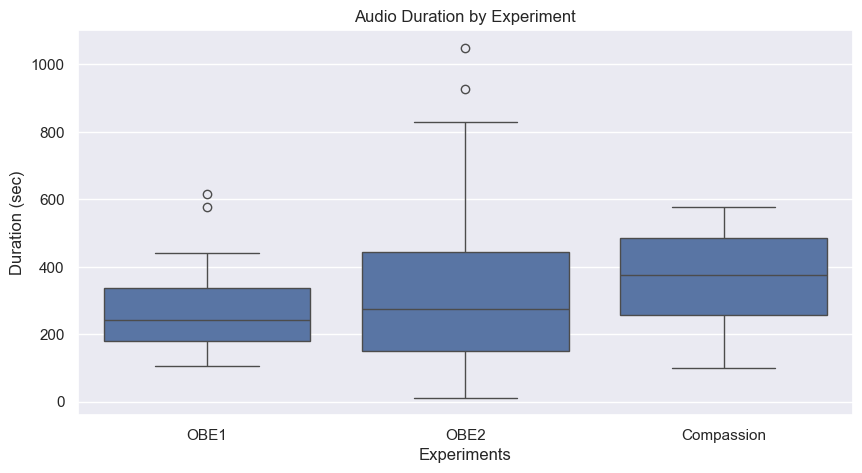

In [11]:
# Set the size of the plot
plt.figure(figsize=(10,5))

# Create a box plot with seaborn
sns.boxplot(x='Experiment', y='Duration_sec', data=df)

# Add titles and labels
plt.title('Audio Duration by Experiment')
plt.xlabel('Experiments')
plt.ylabel('Duration (sec)')

# Show the plot
plt.show()

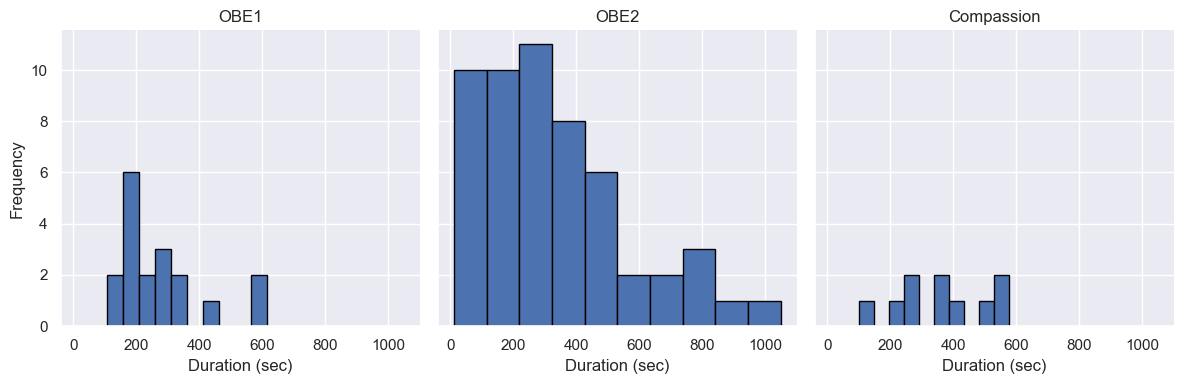

In [12]:
# Create a FacetGrid for separate histograms for each experiment
g = sns.FacetGrid(df, col="Experiment", col_wrap=3, height=4)

# Map the data to histograms, using the 'Duration_sec' column (in seconds)
g.map(plt.hist, "Duration_sec", bins = 10 ,edgecolor='black') #color='skyblue', bins=10

# Add a title and adjust layout
g.set_titles("{col_name}")
g.set_axis_labels("Duration (sec)", "Frequency")

plt.tight_layout()
plt.show()

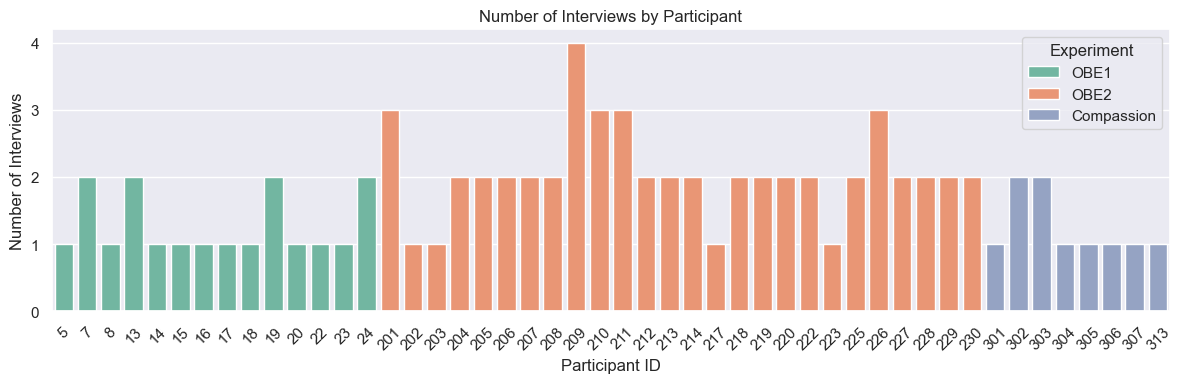

In [16]:
plt.figure(figsize=(12, 4))

# Group by 'ID' and 'Experiment', then count interviews
sns.countplot(x='ID', hue='Experiment', data=df, palette='Set2')

# Title and labels
plt.title('Number of Interviews by Participant')
plt.xlabel('Participant ID')
plt.ylabel('Number of Interviews')
plt.xticks(rotation=45)

# Set y-axis to show only integers
plt.yticks(range(0, int(df['ID'].value_counts().max()) + 1))

# Add legend
plt.legend(title='Experiment')

# Show the plot
plt.tight_layout()
plt.savefig('interviews_by_participant.png', dpi=600)
plt.show()

# Estimation of time passed verify transcription

In [ ]:
df = pd.read_csv("time_data.csv")

# Function to convert HH:MM:SS to total seconds
def time_to_seconds(time_str):
    try:
        h, m, s = map(int, time_str.split(':'))
        return h * 3600 + m * 60 + s
    except:
        return np.nan  # Return NaN if time_str is not a valid format

df['Verification_sec'] = df['Verification_time'].apply(time_to_seconds)

# Drop rows where 'Verification_sec' is NaN
df = df.dropna(subset=['Verification_sec'])

df.loc[:, 'Ratio'] = df['Verification_sec'] / df['Duration_sec'] 

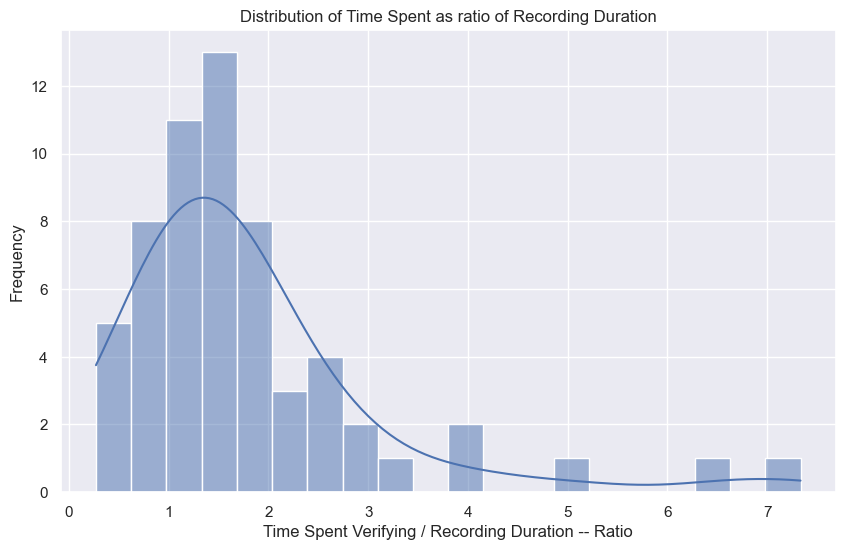

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Ratio'].dropna(), kde=True, bins=20)
plt.title('Distribution of Time Spent as ratio of Recording Duration')
plt.xlabel('Time Spent Verifying / Recording Duration (Ratio)')
plt.ylabel('Frequency')
plt.show()


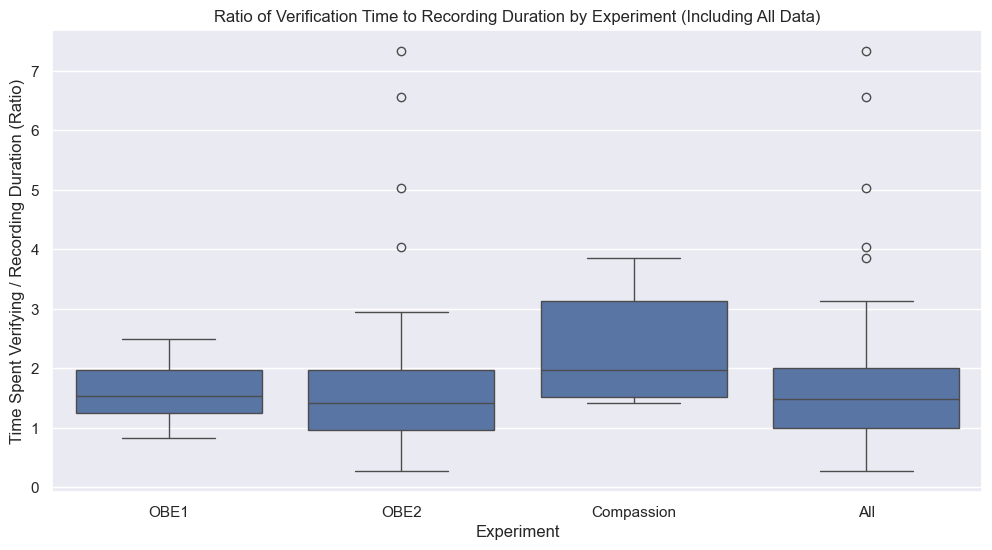

In [ ]:
# Add a new row for the "All" category
df_all = df.copy()
df_all['Experiment'] = 'All'

# Concatenate the original data with the "All" data
df_combined = pd.concat([df, df_all])

# Plot the box plot with "All" as an additional category
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_combined, x='Experiment', y='Ratio')
plt.title('Ratio of Verification Time to Recording Duration by Experiment (Including All Data)')
plt.xlabel('Experiment')
plt.ylabel('Time Spent Verifying / Recording Duration (Ratio)')
plt.show()


# Conditons Structures of Interviews (Conditons & more...)
Final version, need to be fill/verified manually, actually located at **interviews_corrected** folder at main.

## Get the order of the conditions for each experiment
**C** : Control ; **I** : Intervention ; **1** : Only one interview ; **0** : No interview (eg. Set-up)

In [ ]:
df = pd.read_csv("audio_data.csv")
# Compassion
conditions_compassion = pd.read_csv("../../data/Compassion/Compassion_orders.csv")
conditions_compassion["ID"] = conditions_compassion["Number"].apply(extract_id)
# If the first word is control -> CI, otherwise -> IC
conditions_compassion["Order_Condition"] = conditions_compassion["order"].apply(lambda x: "CI" if x.split()[0] == "control" else "IC")

# OBE2
conditions_obe2 = pd.read_excel("../../Data/OBE2/Order_of_conditions.xlsx")
conditions_obe2["ID"] = conditions_obe2["Identification No."].apply(extract_id)
# CM -> CI, otherwise -> IC
conditions_obe2["Order_Condition"] = conditions_obe2["Order"].apply(lambda x: "CI" if x == "CM" else "IC")

# OBE1
conditions_obe1 = pd.read_csv("../../Data/OBE1/order_OBE1.csv")
conditions_obe1["ID"] = conditions_obe1["subjID"]
conditions_obe1["Order_Condition"] = conditions_obe1["order"].apply(lambda x: "CI" if x == "CM" else "IC")

# Create a DataFrame for OBE1 with placeholder '?' for Order_Condition
#obe1_ids = df[df["Experiment"] == "OBE1"]["ID"].unique()
#conditions_obe1 = pd.DataFrame({"ID": obe1_ids, "Order_Condition": None})

# Combine all conditions
conditions = pd.concat([conditions_compassion, conditions_obe2, conditions_obe1], ignore_index=True)
df = pd.merge(df, conditions[["ID","Order_Condition"]], on="ID", how="left")

# Create the 'Condition' column and set initial values to None
df["Condition"] = None
df = df.sort_values(by=['ID', 'File_name'])

def assign_condition(row):
    # Get rows for the same ID in any experiment
    id_group = df[df['ID'] == row['ID']]
    
    # If there is only one file for this ID, set Condition to "1"
    if len(id_group) == 1:
        return "1"
    
    # Assign 'Condition' based on alphabetical order in 'OBE2' and 'OBE1'
    if row['Experiment'] in ['OBE1', 'OBE2']  and len(id_group) == 2:
        if row.name == id_group.index[0]:
            return row['Order_Condition'][0]
        elif row.name == id_group.index[1]:
            return row['Order_Condition'][1]
    
    # For other cases, leave Condition as None
    return row['Condition']

# Apply the function to assign conditions
df['Condition'] = df.apply(assign_condition, axis=1)

# Select specific columns and save the final structured data
df = df[["Experiment", "File_name", "ID", "Duration", "Order_Condition", "Condition"]]

df.to_csv("structured_data.csv", index=False)
df

,Experiment,File_name,ID,Duration,Order_Condition,Condition
0,OBE1,ID 05,5,00:10:15,IC,1
15,OBE1,Id 7a,7,00:09:38,IC,I
16,OBE1,Id 7b,7,00:04:01,IC,C
1,OBE1,Id 08,8,00:04:34,CI,1
2,OBE1,Id 13,13,00:07:19,IC,I
...,...,...,...,...,...,...
77,Compassion,S304,304,00:07:05,CI,1
78,Compassion,S305con,305,00:01:41,CI,1
79,Compassion,S306,306,00:08:50,IC,1
80,Compassion,S307,307,00:06:15,CI,1
